In [1]:
# Build a Deep CNN Image Classifier with ANY Images - https://www.youtube.com/watch?v=jztwpsIzEGc&ab_channel=NicholasRenotte
# Any othere important comments here


In [2]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
import tensorflow as tf
import os

In [4]:
# tf.compat.v1.enable_eager_execution()

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth - Works only with Nvidia Graphics - 2022
# Prevent from geeting all GPU RAM's by tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

1.2 Remove all Iamges with wrong extensions etc.

In [7]:
import cv2
import imghdr
import shutil

In [8]:
data_dir = 'data_v2'

In [9]:
image_extensions = ['jpeg', 'jpg', 'bmp', 'png'] # List of available extensions

In [10]:
#tf.data.Dataset

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
# Loading Data - Create datasets with labels (subdirectory names). Split for n-counts of batches with size of 32 (default)
data = tf.keras.utils.image_dataset_from_directory('data_v2', image_size=(224,224)) 

# It is working as Generator - do not loading files into memory
# Automaticly resize images - unified size of image 256x256 and create batches of images to maintain better prformance. 
# If our PC got not as much memory on GPU as it is needed, we can change size of batch ora change size of images 

Found 366 files belonging to 2 classes.


In [13]:
tf.keras.utils.image_dataset_from_directory?

In [14]:
data_iterator = data.as_numpy_iterator() 

In [15]:
batch = data_iterator.next() # This line grab the batches from pipeline - again and again and again

In [16]:
# Images represented as numpy arrays
len(batch) # Print 2 - one for images in batches in te shape of numpy array
batch[0] # Print values from first position in batch
batch[0].shape # Show how many images are in a batch - in this case 32 it can be modified

(32, 224, 224, 3)

In [17]:
batch[1] # Labels of the images taken from directors contained in main directory

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1])

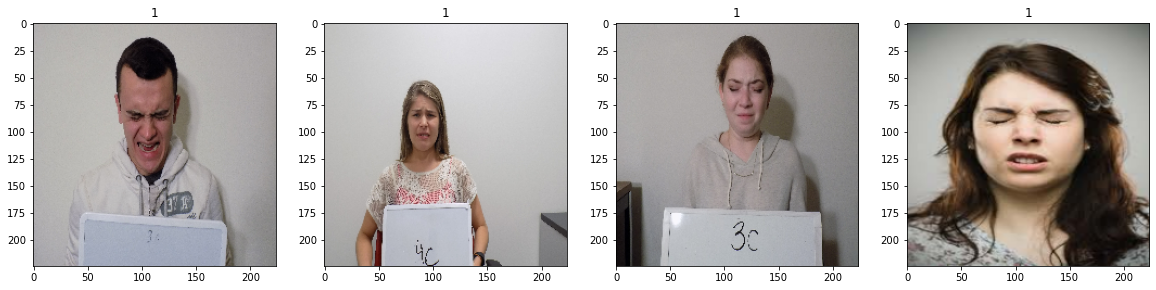

In [18]:
fig, ax = plt.subplots( ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

    # Quick check which label is for which picture. In this case 0 - happy, 1 - sad


2. Preprocess Data

2.1 Scale Data

In [19]:
data = data.map(lambda x,y: (x/255, y)) # Allows create transformation in pipline

In [20]:
scaled_iterator = data.as_numpy_iterator()

In [21]:
batch = scaled_iterator.next()

In [22]:
batch[0].min()

0.0

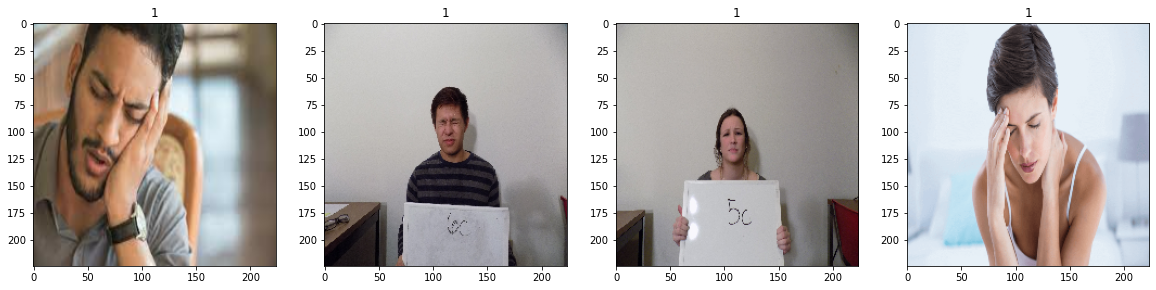

In [23]:
fig, ax = plt.subplots( ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

2.2 Split Data to Training and Testing 

In [24]:
len(data) # How many batches have we got. This example: 7 batches with 32 images each

12

In [25]:
# Split batches between training, validation and testing
# The sum of each has to equal the number of batches.
# In this case we got 7 batches: 4 for training, 2 for validation and 1 for testing.
train_size = int(len(data)*.7)-2
val_size = int(len(data)*.2)+2
test_size = int(len(data)*.1)+1

# train and val data is used in trianing process. Training data allow us to trian deep learning network, validation is for model checking
# test batch is to check the results of training our network -> used at the end

In [26]:
train_size

6

In [27]:
val_size

4

In [28]:
test_size

2

In [29]:
batches_size = train_size + val_size + test_size

In [30]:
batches_size

12

In [31]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# We allocate the batches of date to further training, validation and testing process. 
# .take() -> takes applied value of batches.
# .skip() -> skip applied value of batche.

# Important ! -> batches has to be shuffled before this process, and can not be shuffled after.
# It is, because we neeed to keep the order of taken batches to apply skip() function to work
# If we wanna shuffle data we has to back to: data = tf.keras.utils.image_dataset_from_directory('data'), and create new, shuffled batches

3. Deep model Creation

3.1 Build Deep Learning Model

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import keras
from keras.utils.vis_utils import plot_model
import graphviz
import pydot


In [33]:
model = Sequential()

In [34]:
# 3 - Convlutinal Layers, 1 - Flatten layer, 2 - Dense layers

# Conolutional Layer and MaxPooling Layer
# We got: 16 filters catching key features from picture. 3x3 -> 3px by 3px filters size, 1 stride -> moves the 3x3 squer one pixel each time
# activation = 'relu' -> the function we use to change input date. Relu changes all negative numbers to 0, 
# and the positive numbers multipl by a special value. There are many of activation functions. 
# Non-linear deep learning models are overall better, because deep learning is not linear method
# input_shape - size of images go into model. The sizes has been changed earlier in the program

model.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D()) 
# MaxPoooling2D returns max value, found after activation function. It will condense and scale down the input image. It takes the vlaues from
# region. In default (2,2) -> reduce size by half


model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Number of filters form the channel Value,but we need one chanel value.
# Flatten layer Create one-dimensional dataset, which is required input in Dense layer
model.add(Flatten())


# So we got one-dimensional 256 outputs after Dense function, and later we get 1 output.
# Dense layers are the fully connected layers in the Keras framework,
# We got 256 neurons, and we feed them into Dense layer with relu activation.
# After the second Dense operation we expect the value between 0 and 1 -> due to sigmoid chracteristics
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [35]:
# W have t ocompile our model. We use 'adam' optimizer (one of many)
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [36]:
model.summary() # Allow us to see how the model is converting the input data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 16)       0

In [37]:
# !pip install pydot graphviz pydotplus
# tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

3.2 Train

In [38]:
logdir = "logs"

In [39]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [40]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])
# model.fit(): takes training date (dividie earlier in the code), epoches -> how many times we wnat to train our model 
# -> one epoch is runinng over entire training set of data
# the nwe pass our validation vlaues, so we can know how great performance has our model in real-time domain

Epoch 1/20
6/6 [==============================] - 95s 10s/step - loss: 1.0002 - accuracy: 0.4792 - val_loss: 0.6951 - val_accuracy: 0.4766
Epoch 2/20
6/6 [==============================] - 87s 10s/step - loss: 0.6994 - accuracy: 0.5208 - val_loss: 0.6825 - val_accuracy: 0.5781
Epoch 3/20
6/6 [==============================] - 125s 18s/step - loss: 0.6815 - accuracy: 0.6146 - val_loss: 0.6800 - val_accuracy: 0.5234
Epoch 4/20
6/6 [==============================] - 80s 9s/step - loss: 0.6826 - accuracy: 0.6042 - val_loss: 0.6617 - val_accuracy: 0.7109
Epoch 5/20
6/6 [==============================] - 77s 9s/step - loss: 0.6457 - accuracy: 0.6927 - val_loss: 0.6092 - val_accuracy: 0.6875
Epoch 6/20
6/6 [==============================] - 82s 11s/step - loss: 0.6061 - accuracy: 0.6979 - val_loss: 0.5543 - val_accuracy: 0.7656
Epoch 7/20
6/6 [==============================] - 81s 10s/step - loss: 0.5465 - accuracy: 0.6823 - val_loss: 0.5298 - val_accuracy: 0.6953
Epoch 8/20
6/6 [============

3.3 Plot Performance

In [41]:
hist.history

{'loss': [1.0001651048660278,
  0.6993510127067566,
  0.6814587712287903,
  0.6825516223907471,
  0.6457396149635315,
  0.606062114238739,
  0.5464654564857483,
  0.47457155585289,
  0.4321800470352173,
  0.3434322774410248,
  0.3725251257419586,
  0.33042946457862854,
  0.2397201657295227,
  0.22929108142852783,
  0.20976845920085907,
  0.19447582960128784,
  0.2030884474515915,
  0.14837004244327545,
  0.11654172092676163,
  0.11641019582748413],
 'accuracy': [0.4791666567325592,
  0.5208333134651184,
  0.6145833134651184,
  0.6041666865348816,
  0.6927083134651184,
  0.6979166865348816,
  0.6822916865348816,
  0.78125,
  0.8177083134651184,
  0.8541666865348816,
  0.8645833134651184,
  0.8385416865348816,
  0.8958333134651184,
  0.8958333134651184,
  0.90625,
  0.9114583134651184,
  0.9114583134651184,
  0.953125,
  0.9479166865348816,
  0.96875],
 'val_loss': [0.6951078176498413,
  0.6825190186500549,
  0.6800359487533569,
  0.6616995334625244,
  0.609195351600647,
  0.554301500320

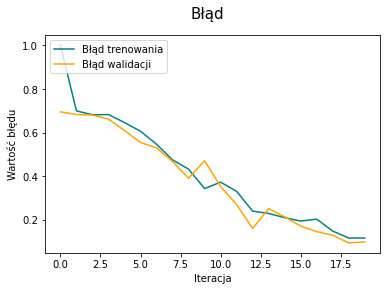

In [42]:
# Cause we saved information in hist variable, we cna now plot some interesting plots
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='Błąd trenowania')
plt.plot(hist.history['val_loss'], color='orange', label='Błąd walidacji')
fig.suptitle('Błąd', fontsize=15)
plt.xlabel('Iteracja', fontsize=10)
plt.ylabel('Wartość błędu', fontsize=10)
plt.legend(loc='upper left')
plt.show()

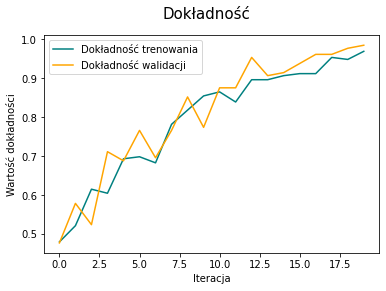

In [43]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='Dokładność trenowania')
plt.plot(hist.history['val_accuracy'], color='orange', label='Dokładność walidacji')
fig.suptitle('Dokładność', fontsize=15)
plt.xlabel('Iteracja', fontsize=10)
plt.ylabel('Wartość dokładności', fontsize=10)
plt.legend(loc='upper left')
plt.show()

4. Evaluate Performance

4.1 Evaluate

In [44]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [45]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [46]:
for batch in test.as_numpy_iterator():
    X, y = batch
    ythat = model.predict(X)
    precision.update_state(y, ythat)
    recall.update_state(y, ythat)
    accuracy.update_state(y, ythat)
    

1/1 [==============================] - 1s 766ms/step


In [47]:
print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}')

Precision: 0.9230769276618958, Recall: 1.0, Accuracy: 0.95652174949646


4.2 Test

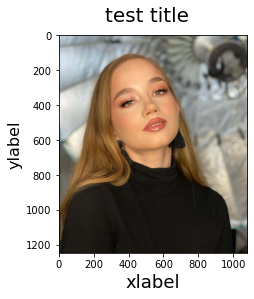

In [56]:
#img = cv2.imread('pain_test.JPG')
img = cv2.imread('test_Data/neutral_test_v2.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig_3 = plt.figure()
plt.imshow(img)
fig_3.suptitle('test title', fontsize=20)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=16)

plt.show()

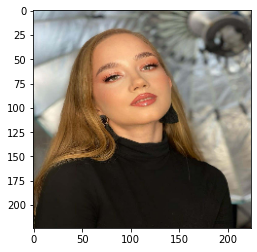

In [57]:
# We resized all batches of data to 256x256 size. The input data has to be the same size !!!
resize_img = tf.image.resize(img, (224,224))
plt.imshow(resize_img.numpy().astype(int))
plt.show()

In [58]:
yhat = model.predict(np.expand_dims(resize_img/255, 0)) 
# The model expect the batch of data not a single image, so we have to wrap data into batch (deeper into the list)

1/1 [==============================] - 0s 74ms/step


In [59]:
yhat
#In this case 0 - happy, 1 - sad

array([[0.5538929]], dtype=float32)

In [60]:
if yhat < 0.5:
    print('We are Normal Normal People, Yuhu :) !!!')
else:
    print("Hello Pain My Old Friend :( ")

Hello Pain My Old Friend :( 


5. Save model

In [ ]:
from tensorflow.keras.models import load_model
import os
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

In [ ]:
#model.save(os.path.join('models', 'pain_detection_model_v2.h5'))

6. Reuse the model

In [ ]:
new_model = load_model(os.path.join('models', 'pain_detection_model_baseCNN.h5'))

In [ ]:
input_img = cv2.imread('test_Data/neutral_test_v1.JPG')
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
plt.imshow(input_img)
plt.show()

In [ ]:
resized_img = tf.image.resize(input_img, (256, 256))
plt.imshow(resized_img.numpy().astype(int))
plt.show()

In [ ]:
yhat_new = new_model.predict(np.expand_dims(resized_img/255, 0))

In [ ]:
yhat_new

In [ ]:
if yhat_new < 0.5:
    print('We are Normal Normal People, Yuhu :) !!!')
    plt.imshow(resized_img.numpy().astype(int))
else:
    print("Hello Pain My Old Friend :( ")
    plt.imshow(resized_img.numpy().astype(int))